In [1]:
import torch
from srm import SRMBlock
from linear_gating import LinearGating

# Set print formatting for readability
torch.set_printoptions(linewidth=200)

# Test case 1: 4x4 input with window_size=2
dummy_input = torch.arange(1, 17).reshape(1, 1, 4, 4).float()
print("Test Case 1 - 4x4 input, window_size=2")
print("Input:")
print(dummy_input)

# Test srm block
srm_block = SRMBlock(window_size=2, in_channels=1, original_height=4, original_width=4)
out = srm_block(dummy_input)
print("\nOutput SRM block:")
print(out)

lg = LinearGating(dim=out.shape[1], use_activation=False)
out_gated = lg(out)
print("\nOutput LG:")
print(out_gated)

with torch.no_grad():
    B, C, H, W = out.shape
    x_reshaped = out.view(B, C, H * W).permute(0, 2, 1)
    gates = lg.fc(x_reshaped)
    print("\nGating values before multiply:")
    print(gates.view(B, C, H, W))


Test Case 1 - 4x4 input, window_size=2
Input:
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

Output SRM block:
tensor([[[[-0.1051,  0.0993,  3.2544,  3.7463],
          [ 0.7124,  0.9167,  5.2220,  5.7139],
          [-1.5750, -1.8084, -4.1292, -4.3499],
          [-2.5083, -2.7416, -5.0123, -5.2331]]]], grad_fn=<CatBackward0>)

Output LG:
tensor([[[[-0.0325,  0.0321,  1.7869,  2.1886],
          [ 0.2618,  0.3502,  3.6012,  4.1412],
          [-0.3214, -0.3388, -0.0891, -0.0253],
          [-0.3446, -0.3309,  0.2080,  0.2998]]]], grad_fn=<ViewBackward0>)

Gating values before multiply:
tensor([[[[ 0.3091,  0.3237,  0.5491,  0.5842],
          [ 0.3675,  0.3821,  0.6896,  0.7248],
          [ 0.2040,  0.1874,  0.0216,  0.0058],
          [ 0.1374,  0.1207, -0.0415, -0.0573]]]])


In [2]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Load Input Blurry Image
load_dir = './Datasets/train/GoPro/input_crops'
name = '000001-1'
img_path = os.path.join(load_dir, name + '.png')

# Load full RGB image (H, W, 3)
input_img = plt.imread(img_path)
print("Loaded shape:", input_img.shape)  # Should be (256, 256, 3)

# Convert to tensor: (1, 3, H, W)
transform = T.Compose([
    T.ToTensor(),  # Converts to [0, 1], shape (C, H, W)
])

input_tensor = transform(input_img).unsqueeze(0)  # → shape: (1, 3, 256, 256)

print("Tensor shape for SRM:", input_tensor.shape)

srm_block = SRMBlock(window_size=4, in_channels=3, original_height=256, original_width=256)
output = srm_block(input_tensor)

print("SRM Output Shape:", output.shape)

# Initialize gating module with correct channel size
gating = LinearGating(dim=output.shape[1], use_activation=False)  # or True if you want sigmoid mask
# 👇 ADD THIS BLOCK right here to initialize to identity
with torch.no_grad():
    gating.fc.weight.copy_(torch.eye(3))
    gating.fc.bias.zero_()

# Apply gating
gated_output = gating(output)

print("Gated Output Shape:", gated_output.shape)

Loaded shape: (256, 256, 3)
Tensor shape for SRM: torch.Size([1, 3, 256, 256])
SRM Output Shape: torch.Size([1, 3, 256, 256])
Gated Output Shape: torch.Size([1, 3, 256, 256])


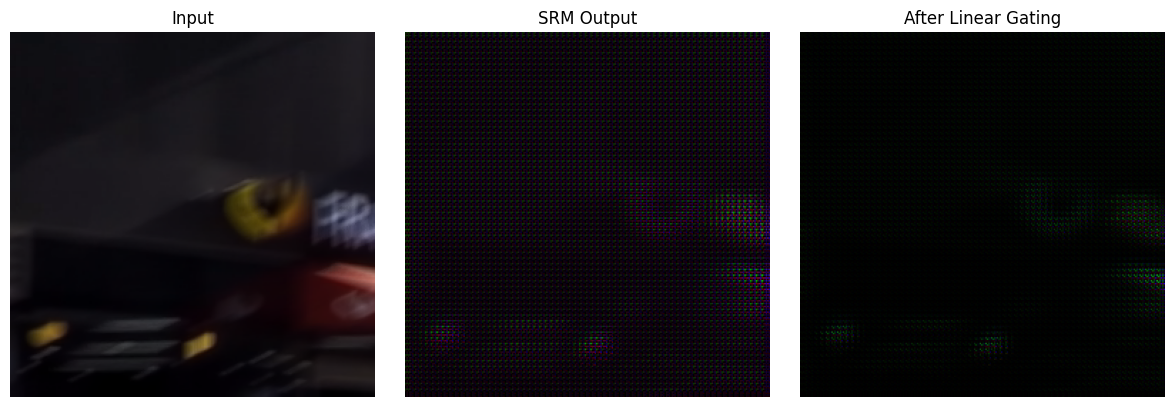

SRM min/max: -0.7702229022979736 0.929868757724762


In [3]:
to_pil = T.ToPILImage()

# Remove batch dimension and clamp to [0,1] for display
input_img_vis = to_pil(input_tensor.squeeze(0).clamp(0, 1))
output_img_vis = to_pil(output.squeeze(0).clamp(0, 1))
gated_img_vis = to_pil(gated_output.squeeze(0).clamp(0, 1))

# Show them side-by-side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_img_vis)
axs[0].set_title("Input")
axs[1].imshow(output_img_vis)
axs[1].set_title("SRM Output")
axs[2].imshow(gated_img_vis)
axs[2].set_title("After Linear Gating")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

print("SRM min/max:", output.min().item(), output.max().item())


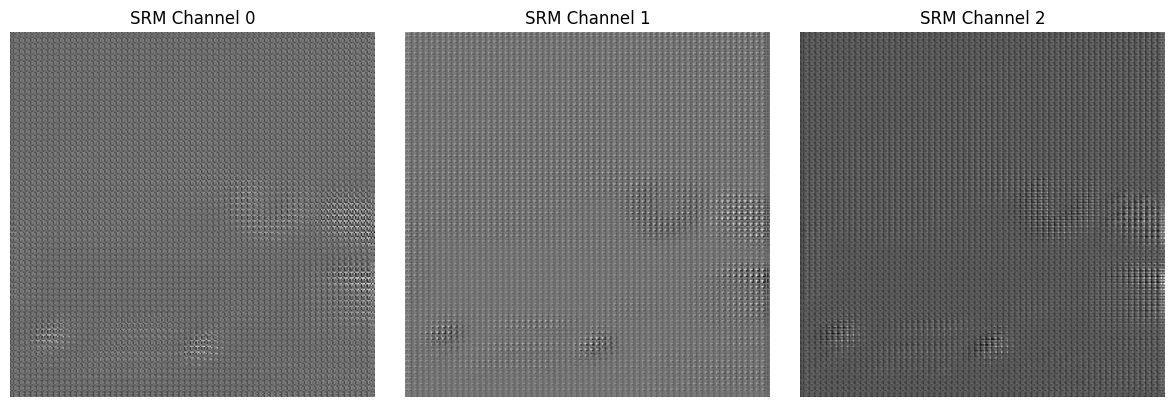

In [4]:
import matplotlib.pyplot as plt

channels = output.squeeze(0)  # shape [3, H, W]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axs[i].imshow(channels[i].detach().cpu().numpy(), cmap='gray')
    axs[i].set_title(f"SRM Channel {i}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()